<a href="https://colab.research.google.com/github/DrYGuo/EELS-aberration-measurements-and-simulations/blob/main/The_2nd_shared_version_of_EELS_Aberration_Measurement_Aug7_with_y_distortion_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruction:

Yueming Guo
Aug, 2021

This program aims to process data for measurement of aberration in EELS spectrometer on MACSTEM. Data are from tilt series experiments controlled by nionswift available from https://github.com/DrYGuo/EELS-aberration-measurements-and-simulations/blob/main/Geometric_chromatic%20aberration%20measurement_rotation_enabled.py
The principle of the data analysis is based on the eikonal approximation, which transforms the quantum mechanical description of electron motion in a EM field to a classical mechanical description by the equation:
$\frac{\partial \chi(\theta_{x},\theta_{y})}{\partial \theta_{x}} = -x $ , where x is the beam motion in the horizontal direction (dispersive direction) in the 2D EELS image.
The derivation of the equation can be found in many quantum mechanics text books. For example, equation (7.10.12) in *Lectures on quantum mechanics* by Steven Weinberg shows its [dual space](https://en.wikipedia.org/wiki/Dual_space) counterpart $\nabla S=\boldsymbol{p} $


The datasets are available from https://zenodo.org/record/8011882. The datasets are big, each has a size of ~800 Mb. Download the datasets locally and upload through goole colab.

# Load modules and data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import dm3_lib
import skimage.feature
from matplotlib.patches import Circle
import matplotlib.colors
import scipy.ndimage
#from numba import jit
from collections import namedtuple
!pip install scikit-image
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Change the paths accordingly.

In [3]:
path_EELS_best='/content/drive/Shareddrives/TMD_NIST/MACSTEM data/EELS aberration project/Aug 7/EELS_data_3D_best.ndata1'
path_EELS_low='/content/drive/Shareddrives/TMD_NIST/MACSTEM data/EELS aberration project/Aug 7/EELS_data_3D_low_order_dominant.ndata1'
path_EELS_high='/content/drive/Shareddrives/TMD_NIST/MACSTEM data/EELS aberration project/Aug 7/EELS_data_3D_high_order_dominant.ndata1'

In [4]:
path_Ronchi_best='/content/drive/Shareddrives/TMD_NIST/MACSTEM data/EELS aberration project/Aug 7/Ronchi_data_best.ndata1'
path_Ronchi_low='/content/drive/Shareddrives/TMD_NIST/MACSTEM data/EELS aberration project/Aug 7/Ronchi_data_low_order_dominant.ndata1'
path_Ronchi_high='/content/drive/Shareddrives/TMD_NIST/MACSTEM data/EELS aberration project/Aug 7/Ronchi_data_high_order_dominant.ndata1'

Extract data from ndata1 files

In [5]:
def extract_data(path):
   zipped=np.load(path)
   data=zipped['data']
   return data


In [6]:
def extract_metadata(path):
   zipped=np.load(path)
   meta_data=zipped['metadata.json']
   return meta_data

In [7]:
EELS_best=extract_data(path_EELS_best)
EELS_low=extract_data(path_EELS_low)
EELS_high=extract_data(path_EELS_high)

In [8]:
Ronchi_best=extract_data(path_Ronchi_best)
Ronchi_low=extract_data(path_Ronchi_low)
Ronchi_high=extract_data(path_Ronchi_high)

In [9]:
Ronchi_metadata_best=extract_metadata(path_Ronchi_best)

check dimensions of the data

In [10]:
print(EELS_best.shape)
print(EELS_low.shape)
print(EELS_high.shape)

print(Ronchi_best.shape)
print(Ronchi_low.shape)
print(Ronchi_high.shape)

(1920, 1920, 49)
(1920, 1920, 49)
(1920, 1920, 49)
(2048, 2048, 49)
(2048, 2048, 49)
(2048, 2048, 49)


The number of tilts

In [11]:
num_tilts=EELS_best.shape[2]

check calibration in metadata of Ronchi

In [12]:
Ronchi_metadata_best

b'{"version": 1, "reader_version": 1, "large_format": true, "spatial_calibrations": [{"offset": 0.0, "scale": 1.0, "units": ""}, {"offset": 0.0, "scale": 1.0, "units": ""}, {"offset": 0.0, "scale": 1.0, "units": ""}], "intensity_calibration": {"offset": 0.0, "scale": 1.0, "units": ""}, "collection_dimension_count": 2, "datum_dimension_count": 1, "metadata": {}, "properties": {}, "title": "Ronchi_data", "source_file_path": null, "datetime_modified": {"local_datetime": "2021-08-07T23:47:28.419766", "tz": "-0400", "dst": "+60", "timezone": "America/New_York"}, "datetime_original": {"local_datetime": "2021-08-07T23:47:28.419766", "tz": "-0400", "dst": "+60", "timezone": "America/New_York"}, "uuid": "8908cb69-8471-4f4c-b9f7-4c3c05ed6798"}'

# Display the summed EELS and Ronchi data

In [13]:
plt.set_cmap('jet')

<Figure size 640x480 with 0 Axes>

In [14]:
def EELS_summed(data):
  summed_data=np.sum(data,axis=2)
  plt.figure(figsize=(30,30))
  plt.imshow(summed_data[900:1200,:])
  plt.axis('off')

In [15]:
def Ronchi_summed(data):
  summed_data=np.sum(data,axis=2)
  plt.figure(figsize=(10,10))
  plt.imshow(summed_data)
  plt.axis('off')

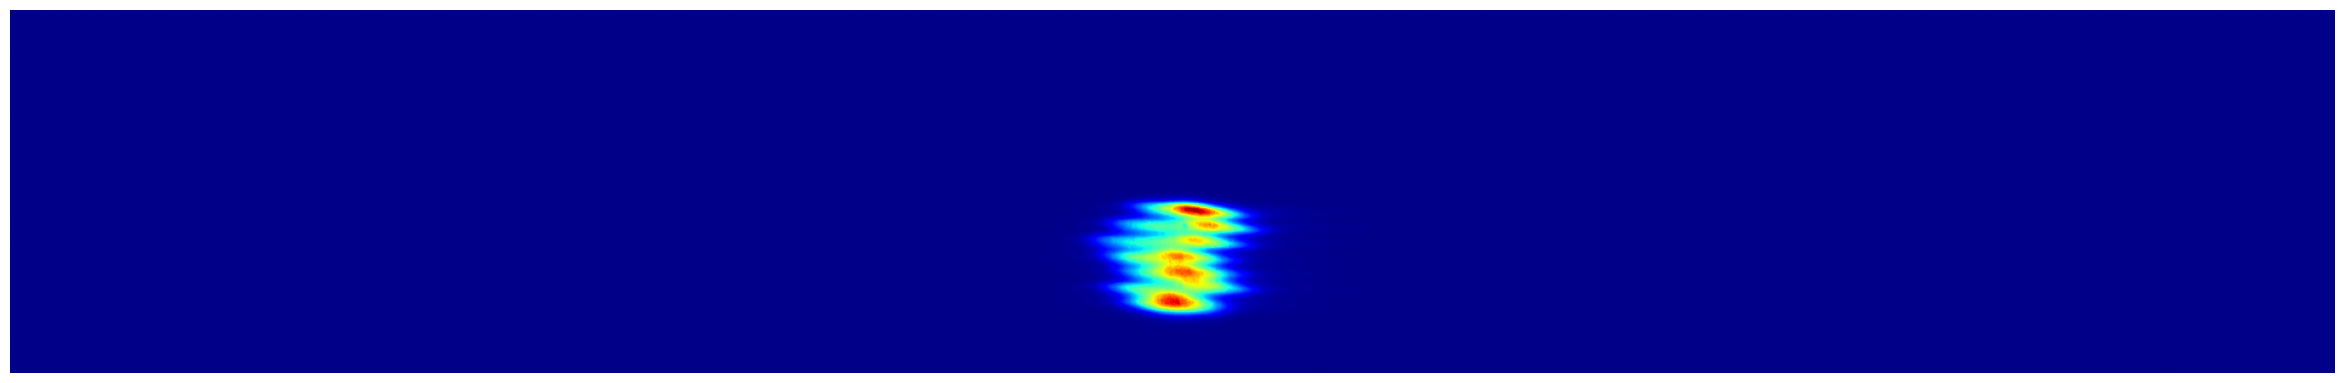

In [16]:
EELS_summed(EELS_best)

The beam shift is quite dominant by beam drift in the image above

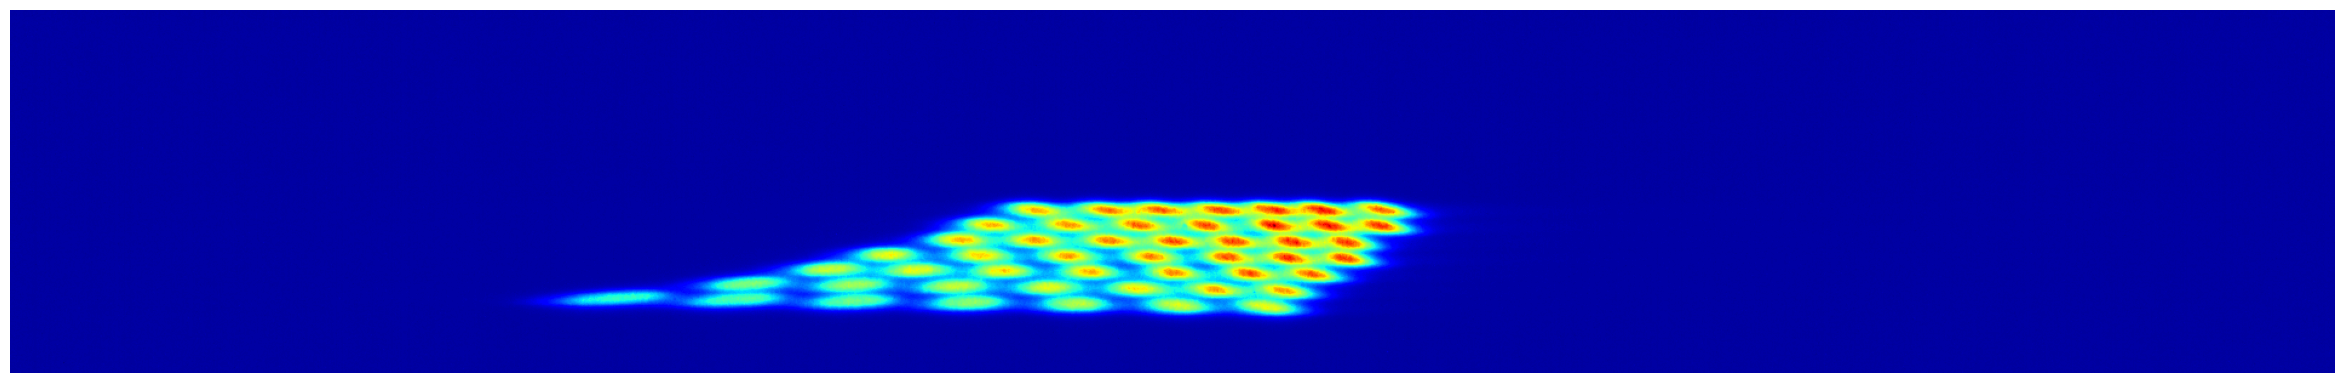

In [17]:
EELS_summed(EELS_low)

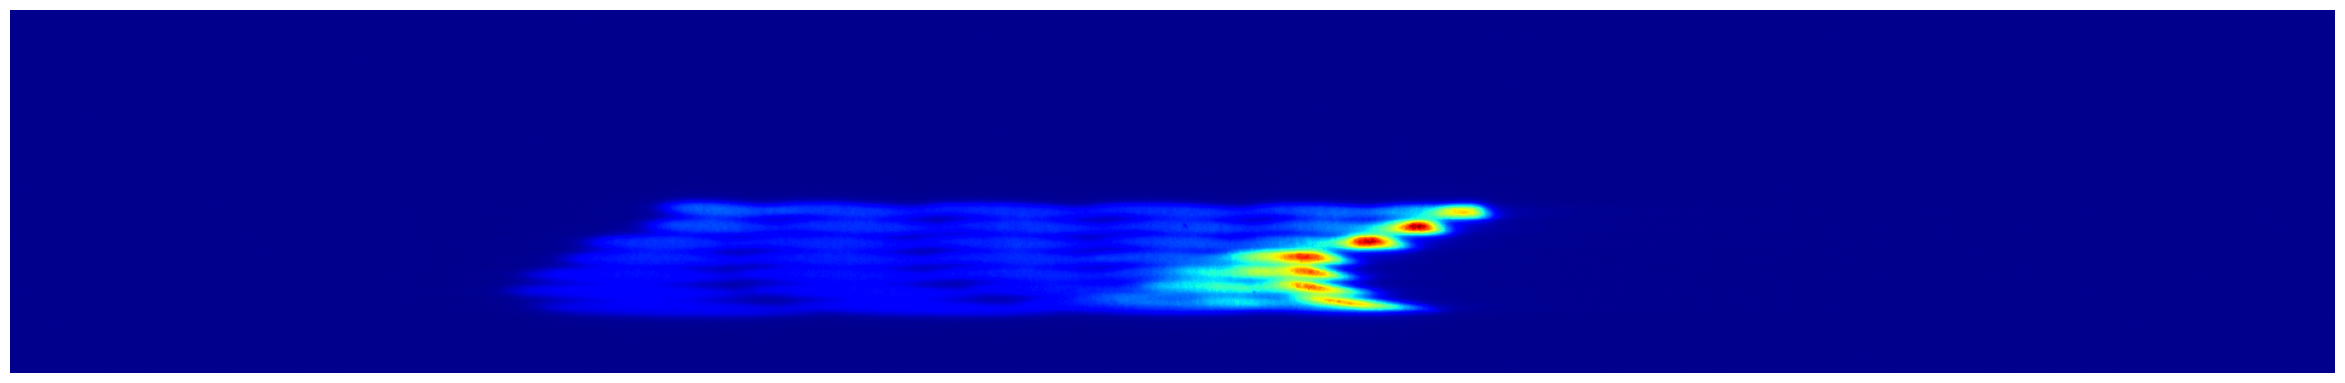

In [18]:
EELS_summed(EELS_high)

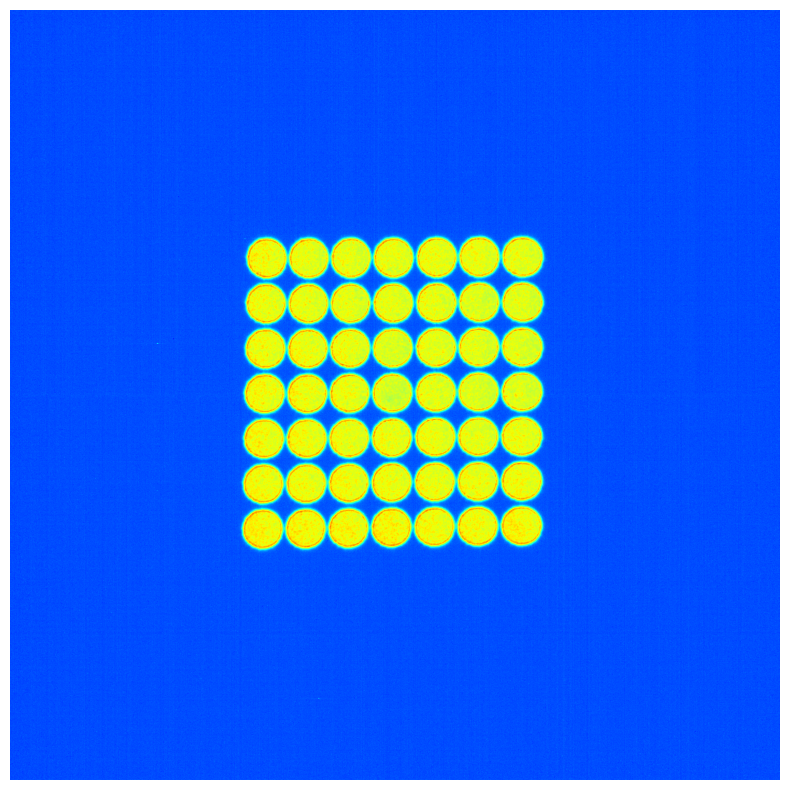

In [19]:
Ronchi_summed(Ronchi_best)

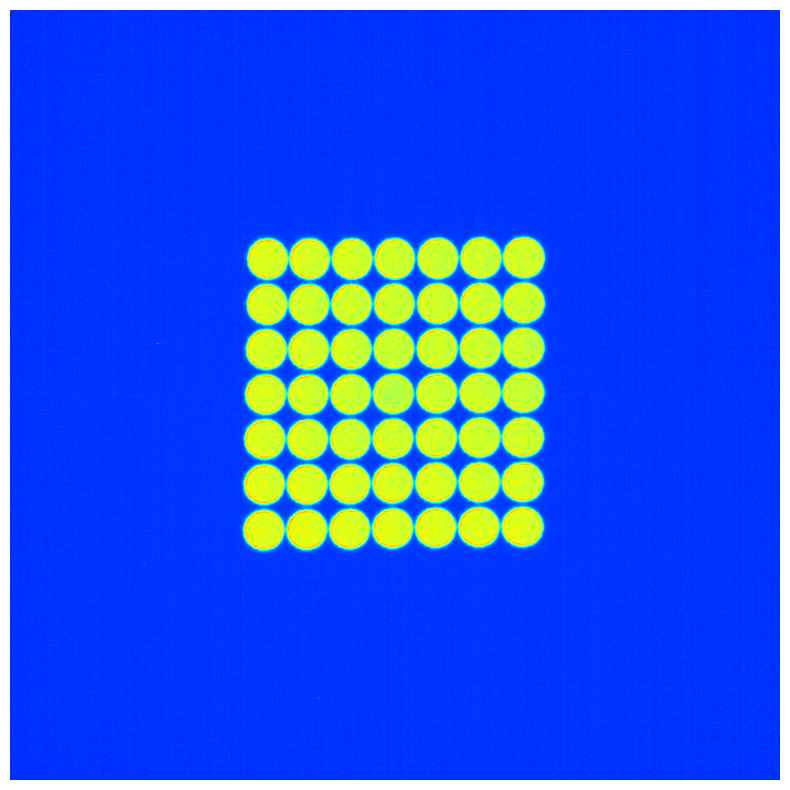

In [20]:
Ronchi_summed(Ronchi_low)

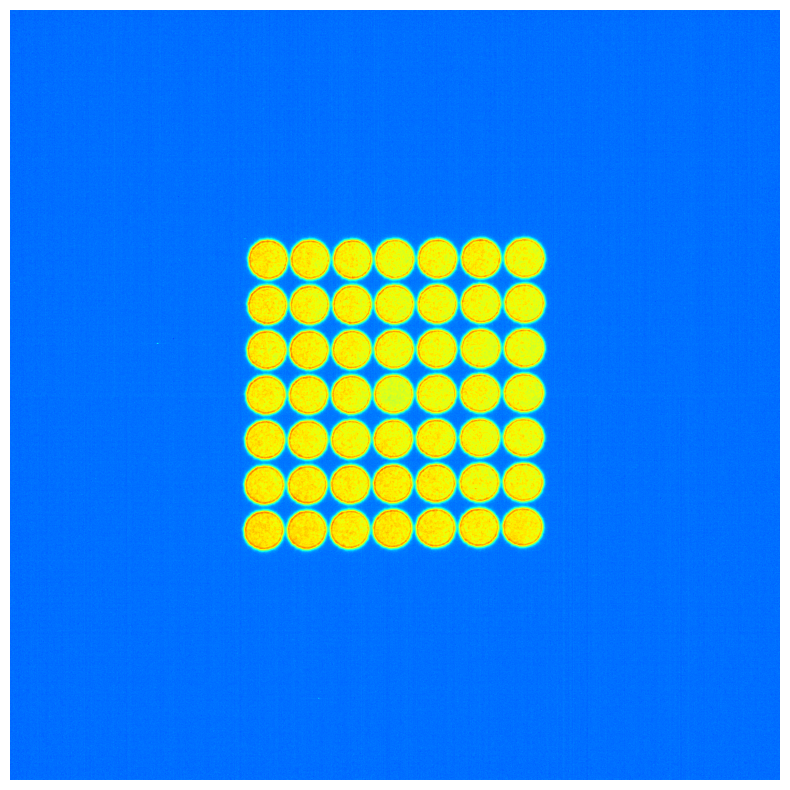

In [21]:
Ronchi_summed(Ronchi_high)

# Display the interactive plot for each tilt

In [22]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def Interactive_plot(EELS,Ronchi,num_tilts):
    def F(i):
       fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
       ax1.imshow(EELS[:,:,i][800:1200,:])
       ax1.set_title('EELS camera')
       ax2.imshow(Ronchi[:,:,i])
       ax2.set_title('Ronchi camera')
       plt.axis('off')

    interactive_EELS = interactive(F, i=(0, num_tilts-1))
    interactive_EELS
    return interactive_EELS

You may need to run the following cells to activate the interactive plots

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

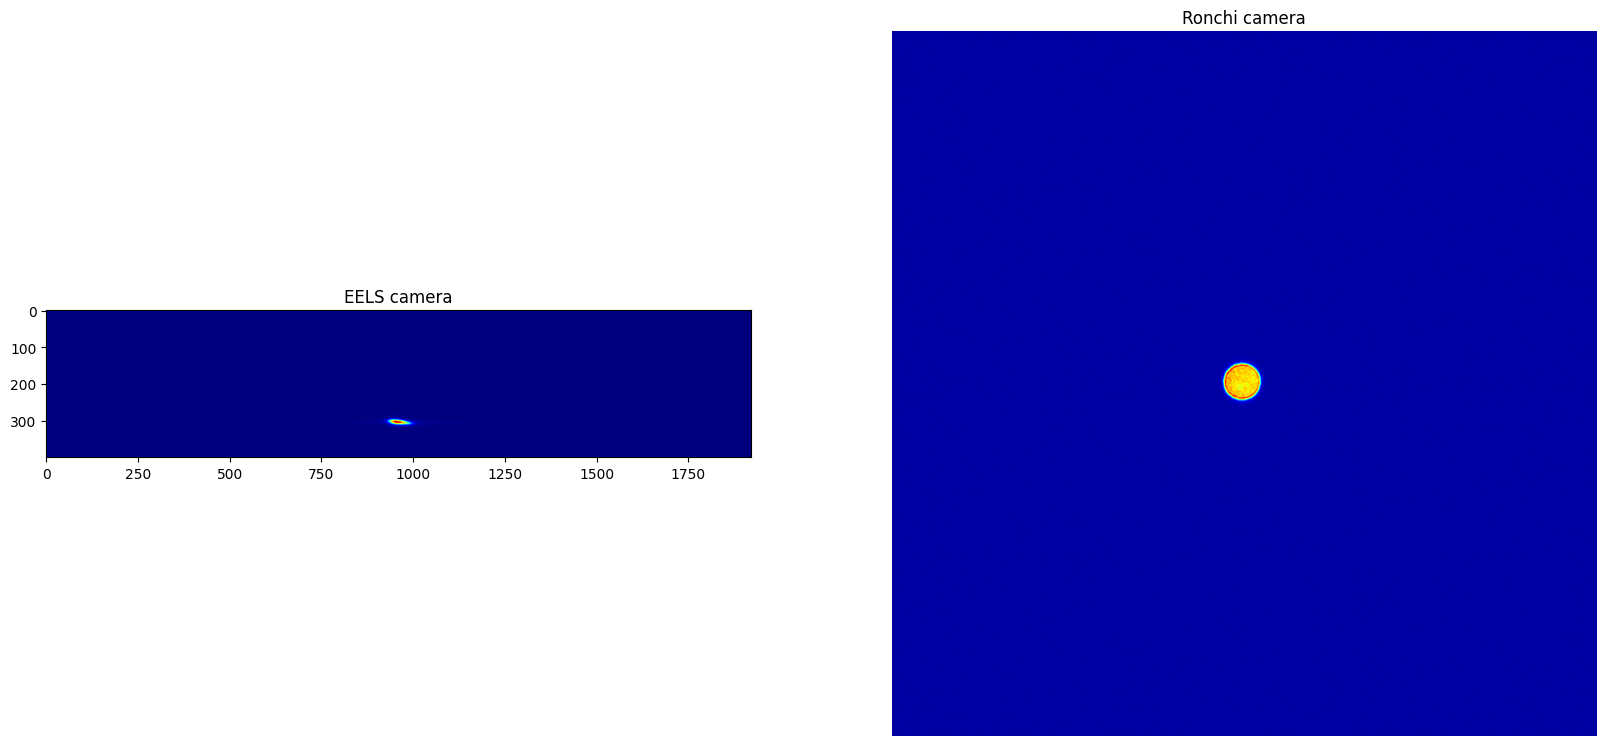

In [23]:
Interactive_plot(EELS_best,Ronchi_best,num_tilts)

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

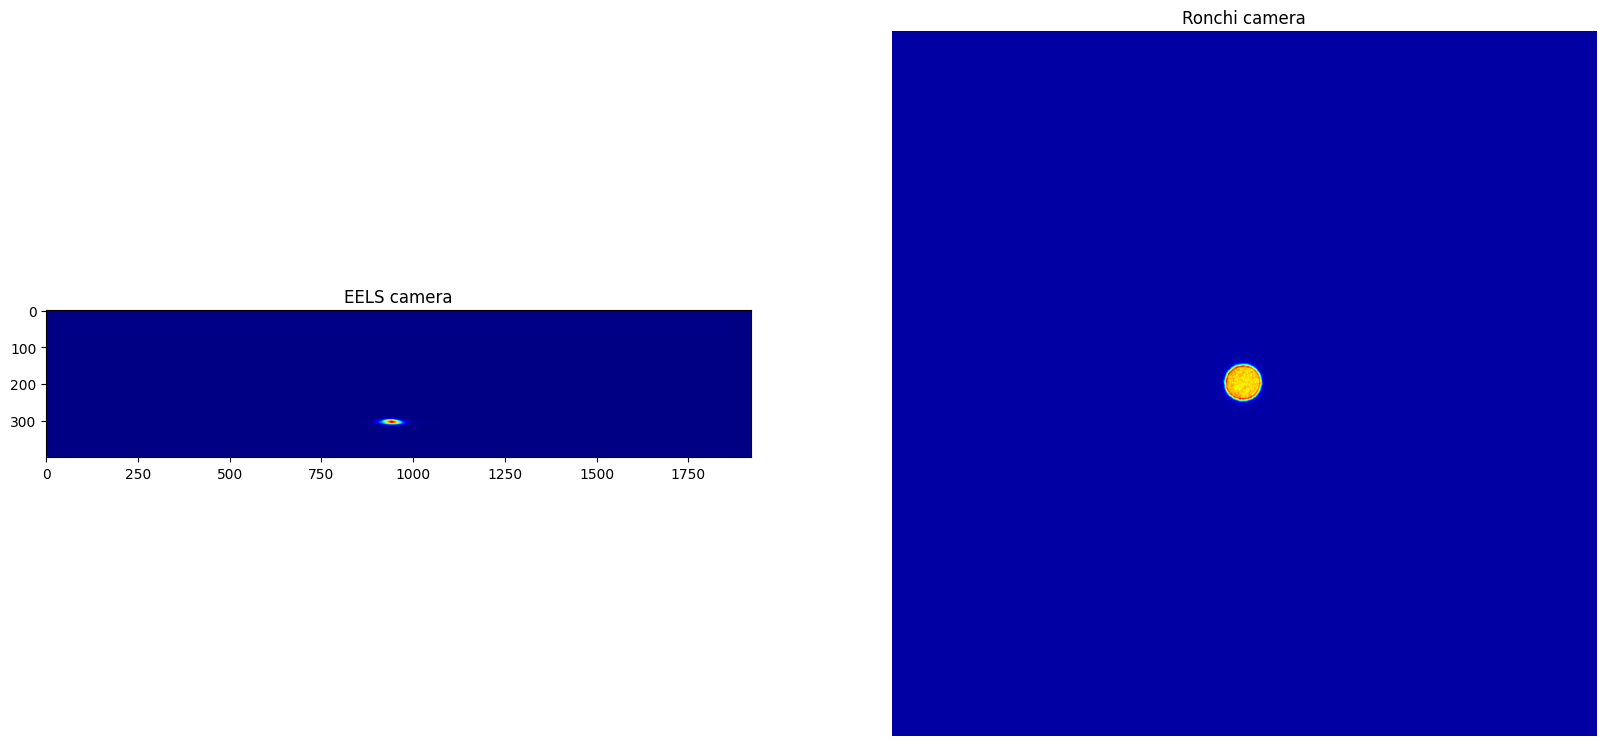

In [24]:
Interactive_plot(EELS_low,Ronchi_low,num_tilts)

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

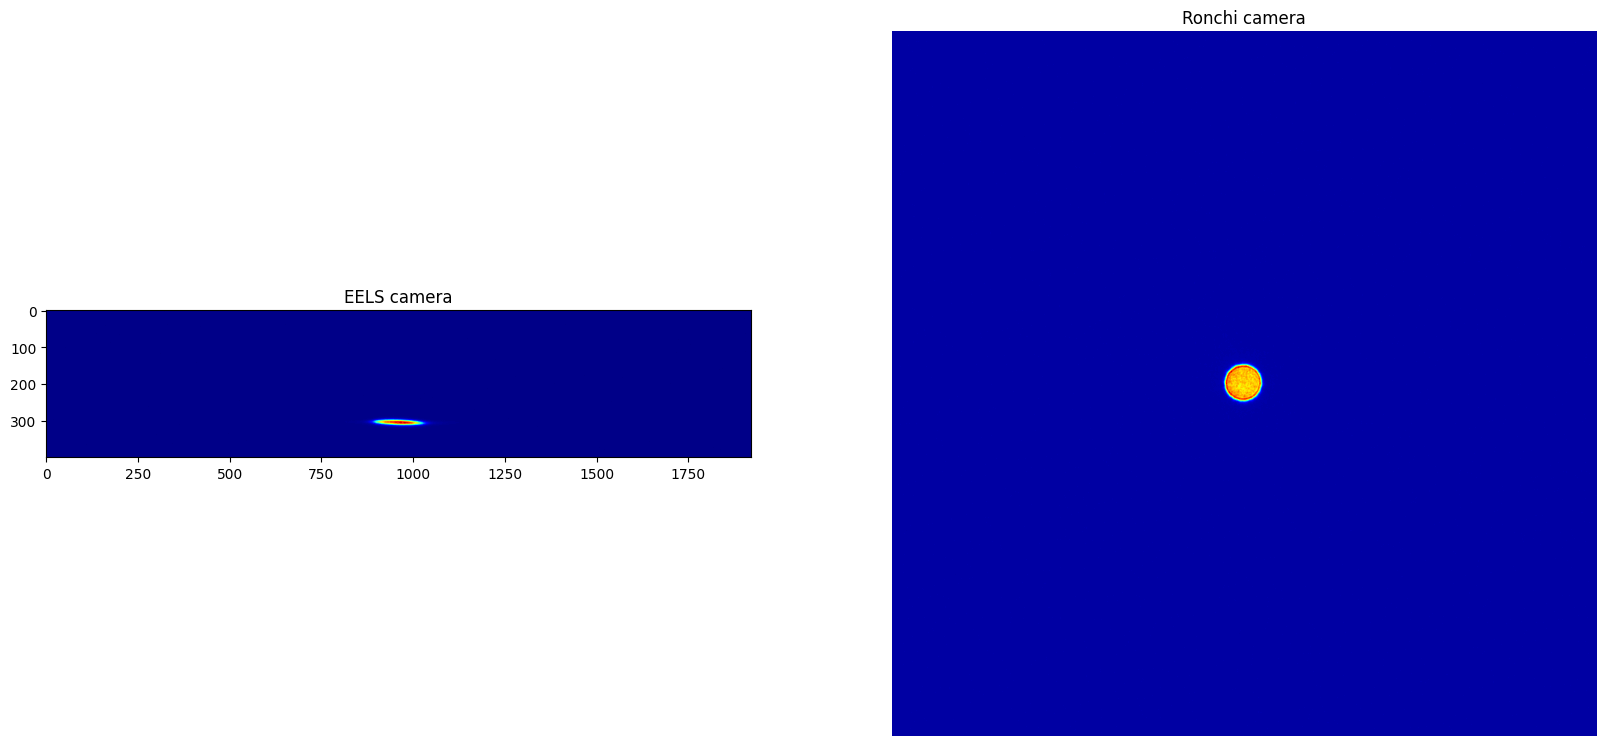

In [25]:
Interactive_plot(EELS_high,Ronchi_high,num_tilts)

(0.0, 15000000.0)

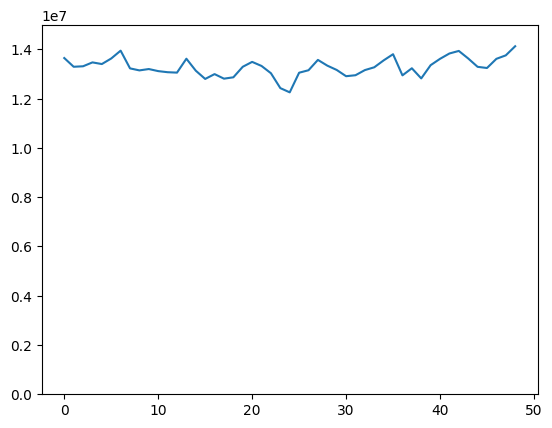

In [26]:
plt.plot(np.sum(Ronchi_best,axis=(0,1)))
plt.ylim(0,1.5e7)

(0.0, 15000000.0)

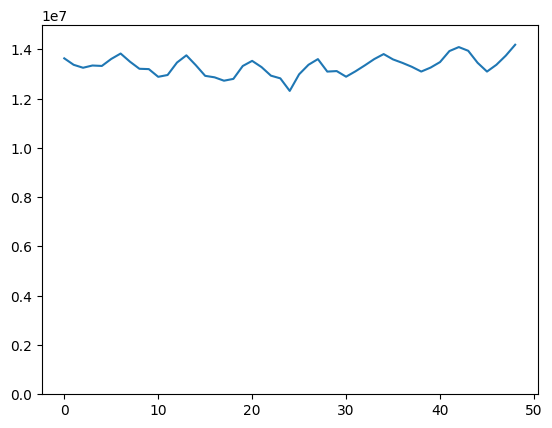

In [27]:
plt.plot(np.sum(Ronchi_low,axis=(0,1)))
plt.ylim(0,1.5e7)

(0.0, 15000000.0)

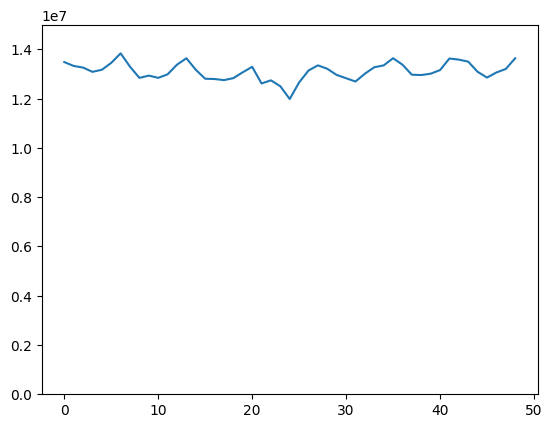

In [28]:
plt.plot(np.sum(Ronchi_high,axis=(0,1)))
plt.ylim(0,1.5e7)

Interactive plots for line profiles in EELS

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

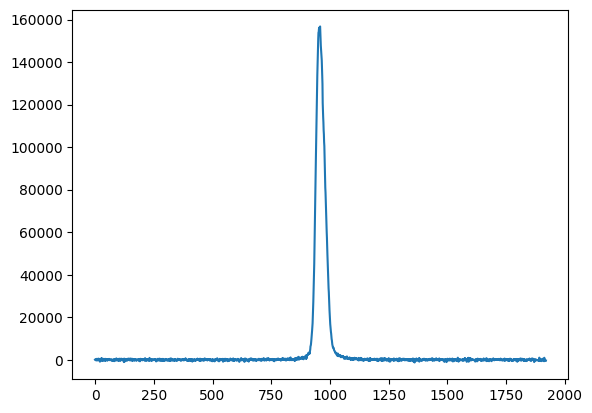

In [29]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def F(i):
  plt.plot(np.sum(EELS_best[:,:,i],axis=0))


interactive_plot = interactive(F, i=(0,num_tilts-1))
interactive_plot

# Get the center of mass for both Ronchi images and EELS line profiles

In [30]:
from scipy import ndimage

In [31]:
def COM(EELS,Ronchi,num_tilts):
    COM_Ronchi=np.zeros((num_tilts,2))
    COM_EELS=np.zeros((num_tilts))
    COM_EELS_Y=np.zeros((num_tilts,2))
    for tilt in range(num_tilts):
      # COM of EELS profiles
      COM_EELS_center=ndimage.center_of_mass(np.sum(EELS[:,:,int(num_tilts/2)],axis=0), labels=None, index=None)[0]
      COM_EELS[tilt]=ndimage.center_of_mass(np.sum(EELS[:,:,tilt],axis=0), labels=None, index=None)-COM_EELS_center

      print(COM_EELS_center)

      # COM of Ronchi
      COM_Ronchi_center_0,COM_Ronchi_center_1=ndimage.center_of_mass(Ronchi[:,:,int(num_tilts/2)], labels=None, index=None)[0],ndimage.center_of_mass(Ronchi[:,:,int(num_tilts/2)], labels=None, index=None)[1]
      COM_Ronchi[tilt,0]=ndimage.center_of_mass(Ronchi[:,:,tilt], labels=None, index=None)[0]-COM_Ronchi_center_0
      COM_Ronchi[tilt,1]=ndimage.center_of_mass(Ronchi[:,:,tilt], labels=None, index=None)[1]-COM_Ronchi_center_1
      print(str(int((tilt+1)/(num_tilts+1)*100))+'%finished')
      print(tilt,COM_Ronchi[tilt,0],COM_Ronchi[tilt,1])
    return COM_EELS,COM_Ronchi

def COM2(EELS,Ronchi,num_tilts):
    # Return the center of mass of the EELS and Ronchigrams
    COM_Ronchi=np.zeros((num_tilts,2))
    COM2_EELS=np.zeros((num_tilts,2))
    for tilt in range(num_tilts):
      COM2_EELS[tilt]=ndimage.center_of_mass( EELS[:,:,tilt], labels=None, index=None)

      COM_Ronchi[tilt]=ndimage.center_of_mass(Ronchi[:,:,tilt], labels=None, index=None)
    COM2_EELS-=   COM2_EELS[len(COM2_EELS)//2]
    COM_Ronchi-= COM_Ronchi[len(COM_Ronchi)//2]
    return COM2_EELS,COM_Ronchi

# Test it:
#COM_EELS_best2,COM_Ronchi_best2=COM2(EELS_best,Ronchi_best,num_tilts)


In [32]:
COM_EELS_best,COM_Ronchi_best=COM(EELS_best,Ronchi_best,num_tilts)
COM_EELS_low,COM_Ronchi_low=COM(EELS_low,Ronchi_low,num_tilts)
COM_EELS_high,COM_Ronchi_high=COM(EELS_high,Ronchi_high,num_tilts)

COM2_EELS_best,COM_Ronchi_best=COM2(EELS_best,Ronchi_best,num_tilts)
COM2_EELS_low,COM_Ronchi_low=COM2(EELS_low,Ronchi_low,num_tilts)
COM2_EELS_high,COM_Ronchi_high=COM2(EELS_high,Ronchi_high,num_tilts)

962.1013251567704
2%finished
0 -344.92439082580245 -332.59252631223853
962.1013251567704
4%finished
1 -225.87871145478493 -334.43868707897263
962.1013251567704
6%finished
2 -109.93279644212225 -334.8260350499364
962.1013251567704
8%finished
3 10.182062815670633 -334.218971639306
962.1013251567704
10%finished
4 121.20793472035962 -338.1379804201315
962.1013251567704
12%finished
5 241.31578809801795 -336.15795306261725
962.1013251567704
14%finished
6 358.0605576990956 -337.86176538782934
962.1013251567704
16%finished
7 -347.3699299769406 -218.04439064900328
962.1013251567704
18%finished
8 -227.21179795962485 -222.14162860926137
962.1013251567704
20%finished
9 -109.36885229085146 -222.30448200571243
962.1013251567704
22%finished
10 7.810175989709478 -225.3894472270821
962.1013251567704
24%finished
11 125.98747055459944 -228.03411666695808
962.1013251567704
26%finished
12 244.20684705496456 -229.823440376677
962.1013251567704
28%finished
13 357.58550089228265 -228.73268137004584
962.101325

In [33]:
COM_EELS_best

array([-10.78885354,  -7.88582667,  -2.64425831,   4.47267239,
         7.84098254,   7.432523  ,  12.37076089, -28.69278109,
       -21.10137462, -13.64387906,   6.28376949,  24.50235193,
        31.07654322,  33.84449791, -20.49892408, -10.48004447,
         2.37364694,   7.39696848,  14.72517656,  18.63171208,
        27.3340433 , -35.15914332, -26.5450247 , -14.03227122,
         0.        ,  10.9026564 ,  15.3135725 ,  15.05706349,
       -44.89532835, -29.35600036, -10.97426755,   5.53024954,
        19.79979695,  29.75049212,  28.29746107, -29.69488323,
       -17.52799624,   0.44318236,  19.66593248,  33.42490495,
        39.38821385,  40.34548043, -12.61009272,  -1.16968057,
        10.4740462 ,  22.43757141,  28.82260412,  27.84554657,
        27.58231261])

# Plot Center of mass for EELS profiles and Ronchi

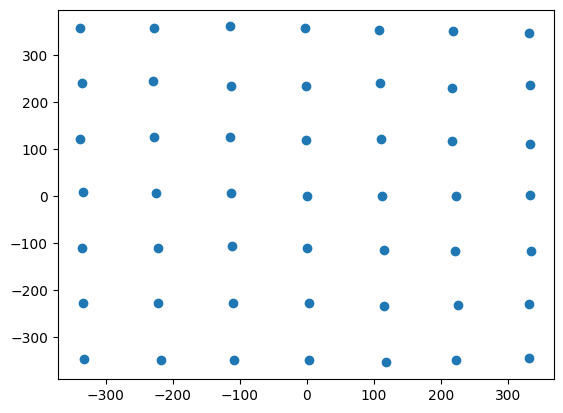

In [34]:
plt.scatter(COM_Ronchi_best[:,1],COM_Ronchi_best[:,0])

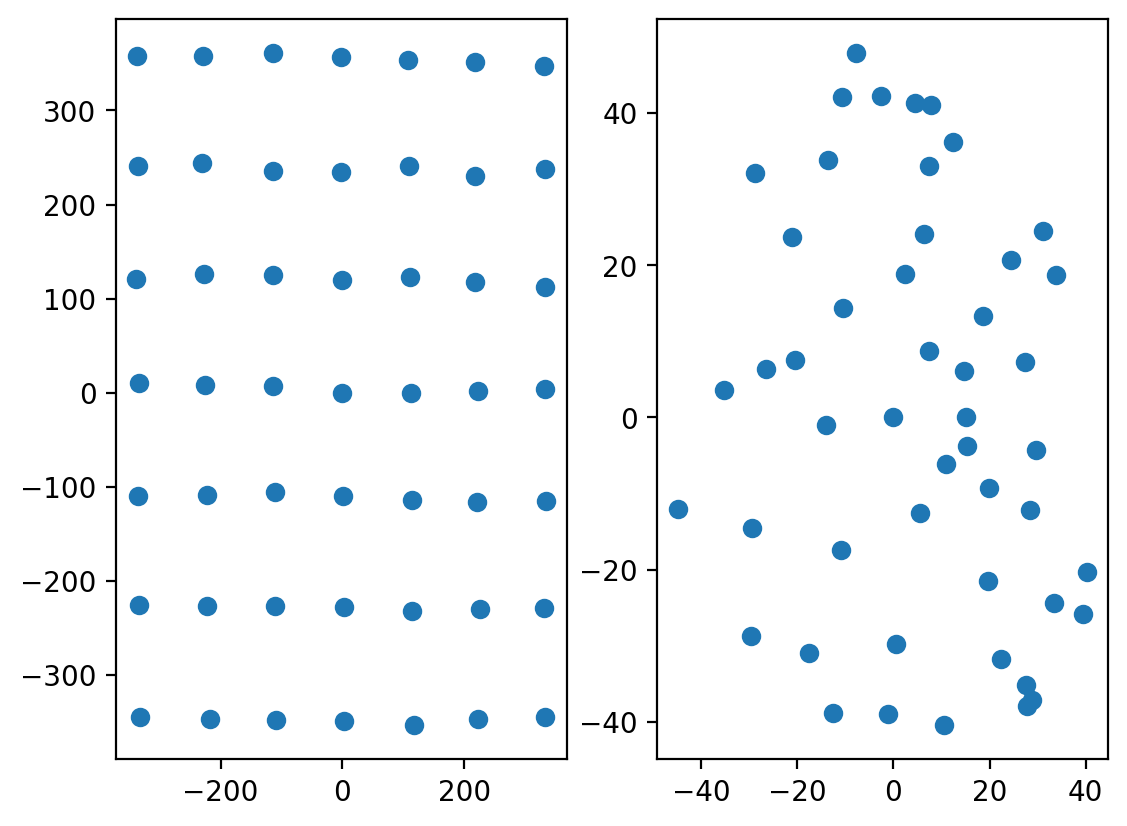

In [35]:
fig,ax = plt.subplots(1,2,dpi=200)
ax[0].scatter(COM_Ronchi_best[:,1],COM_Ronchi_best[:,0])
#ax[1].scatter(COM_Ronchi_best2[:,1],COM_Ronchi_best2[:,0]) # Check it gives the same result
ax[1].scatter(COM2_EELS_best[:,1],COM2_EELS_best[:,0]) # Use like this


Text(0, 0.5, 'COM of EELS line profiles')

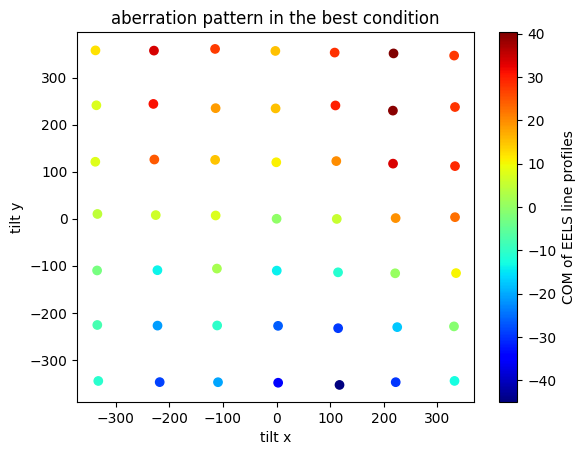

In [36]:
plt.scatter(COM_Ronchi_best[:,1],COM_Ronchi_best[:,0],c=COM_EELS_best[:])
plt.ylabel('tilt y')
plt.xlabel('tilt x')
plt.title('aberration pattern in the best condition')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)

Text(0, 0.5, 'COM of EELS line profiles')

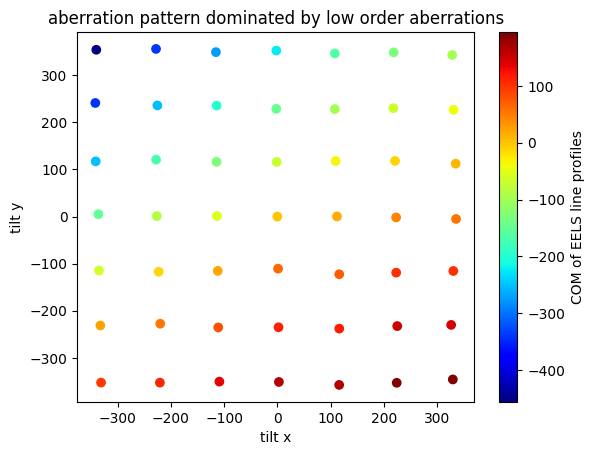

In [37]:
plt.scatter(COM_Ronchi_low[:,1],COM_Ronchi_low[:,0],c=COM_EELS_low[:])
plt.ylabel('tilt y')
plt.xlabel('tilt x')
plt.title('aberration pattern dominated by low order aberrations')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)

In [38]:
1135-1065

70

Text(0, 0.5, 'COM of EELS line profiles')

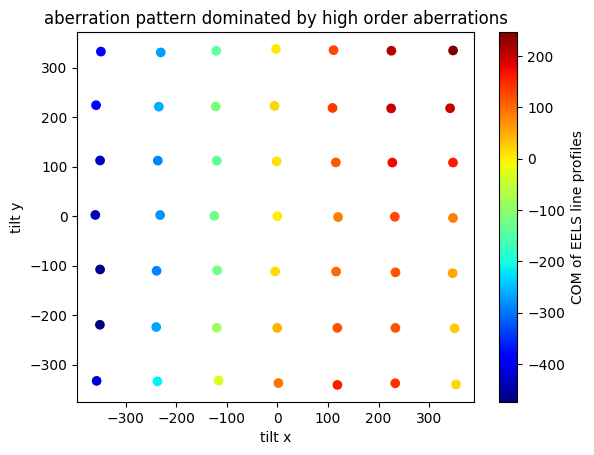

In [39]:
plt.scatter(COM_Ronchi_high[:,0],COM_Ronchi_high[:,1],c=COM_EELS_high[:])
plt.ylabel('tilt y')
plt.xlabel('tilt x')
plt.title('aberration pattern dominated by high order aberrations')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)

# Y-distortion map

To confirm which component of COM2_EELS is Y

Text(0, 0.5, 'COM of EELS line profiles')

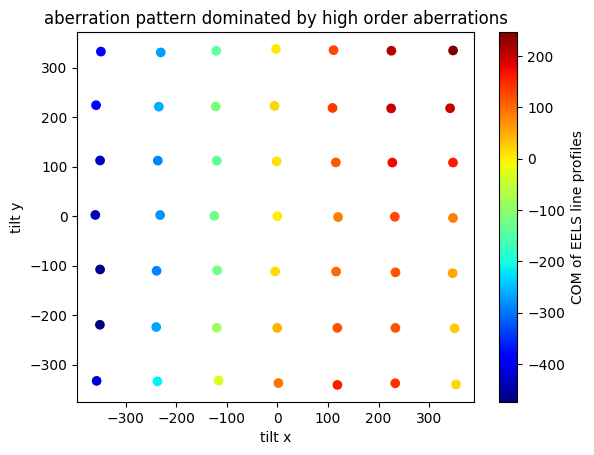

In [40]:
plt.scatter(COM_Ronchi_high[:,0],COM_Ronchi_high[:,1],c=COM2_EELS_high[:,1])
plt.ylabel('tilt y')
plt.xlabel('tilt x')
plt.title('aberration pattern dominated by high order aberrations')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)

The following is the Y distortion map

Text(0, 0.5, 'COM of EELS line profiles')

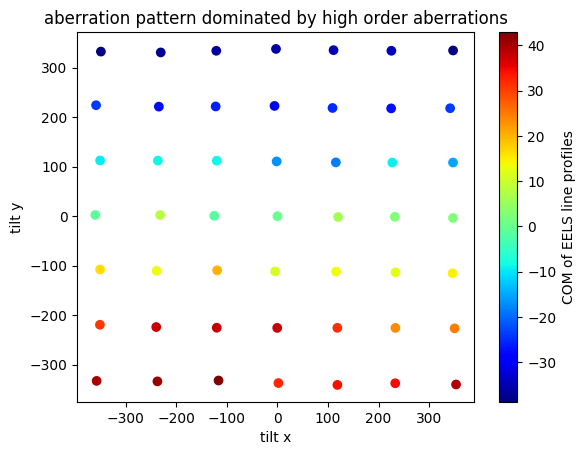

In [41]:
plt.scatter(COM_Ronchi_high[:,0],COM_Ronchi_high[:,1],c=COM2_EELS_high[:,0])
plt.ylabel('tilt y')
plt.xlabel('tilt x')
plt.title('aberration pattern dominated by high order aberrations')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)

### **The COM2_EELS_high[:,0] is the Y-distortion**

Text(0, 0.5, 'COM_Y of EELS line profiles')

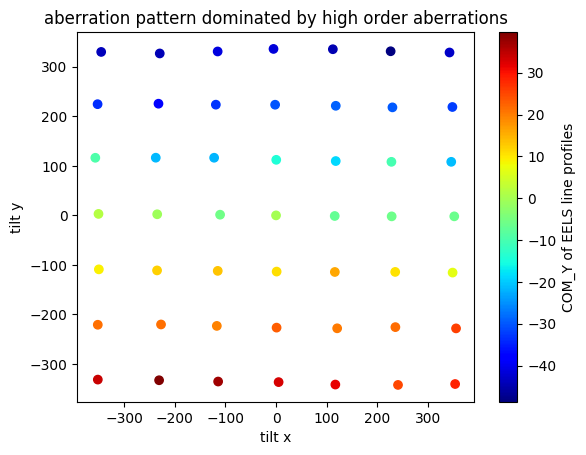

In [42]:
plt.scatter(COM_Ronchi_low[:,0],COM_Ronchi_low[:,1],c=COM2_EELS_low[:,0])
plt.ylabel('tilt y')
plt.xlabel('tilt x')
plt.title('aberration pattern dominated by high order aberrations')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM_Y of EELS line profiles', rotation=90)

# Calibration

For Ronchi

To get the calibration for the diffraction plane, a CBED pattern of a standard sample should be taken. Alternatively, if the calibration is completed for a specific projection setting, then the calibration will be recorded.

In [43]:
calib_Ronchi_1=0.1/1445.37     #rad/pix the values is read from the calibration in
print(str(calib_Ronchi_1)+'rad/pix')

6.918643669095111e-05rad/pix


In [44]:
(COM_Ronchi_low[:,0].max()-COM_Ronchi_low[:,0].min())*calib_Ronchi_1

0.04935689450767015

For EELS camera


1.   The probe is scanned with the descan disabled and a 4-8 us dwell time.
2.   Rotate the scan coil until the horizontal direction of the scan is parallel to the horizontal direction in the EELS camera.
3. Stop scan and draw a box of known size. Place the beam onto the corners and record the beam positions on the EELS camera.



253meV/128nm

In [45]:
covertion=0.253/1280
print(str(covertion)+'eV/Angtrom')

0.00019765625eV/Angtrom


0.4meV/pix

In [46]:
calib_EELS_1=1280/(253/0.4)
print(str(round(calib_EELS_1,2))+'Angstrom/pix (projected to the sample plane)')

2.02Angstrom/pix (projected to the sample plane)


# Polynomial regression(multiple linear regression)
check
https://en.wikipedia.org/wiki/Polynomial_regression for details

## First, specify which dataset to fit

In [47]:
COM_Ronchi=COM_Ronchi_low
COM_EELS=COM_EELS_low

## Second, determine beam tilts from Ronchi camera and shifts from EELS camera

Determine the Beam tilts in rad and list them in mrad (inputs to simulation)

The following lists are measured from Ronchigram data

In [79]:
tiltx=-COM_Ronchi[:,0]*calib_Ronchi_1   # row=-theta_x. Sign flip because of the
tilty=COM_Ronchi[:,1]*calib_Ronchi_1    # col=theta_y
print('These are the inputs to simulation in mrad')
print(tiltx*1000)
print(tilty*1000)

#remove the zero tilt
tiltx=np.delete(tiltx,24,0)
tilty=np.delete(tilty,24,0)
print(tiltx.shape[0])

These are the inputs to simulation in mrad
[ 24.38537895  16.00121425   7.9237125   -0.35141269  -8.11375996
 -16.68803714 -24.5035546   24.3899209   15.73757408   8.10287955
  -0.07389868  -8.36356116 -16.32895038 -24.62845863  24.24344311
  16.28045104   7.97729513  -0.08029376  -8.044931   -16.30308997
 -24.15745004  24.29309569  16.26162858   7.65567869  -0.
  -8.02939731 -15.82032072 -24.38570661  24.72843588  16.45671226
   8.47101155  -0.02678954  -8.16829184 -15.78680111 -23.97122811
  24.41657341  16.08551682   8.23578073   0.12570819  -8.17216351
 -15.92520047 -24.12903454  23.92445976  15.91142441   7.98955337
   0.34666024  -7.7731918  -15.67992094 -23.73634935]
[-22.93508962 -23.02598333 -23.20545256 -23.28538147 -23.62657301
 -23.67912526 -23.5523327  -15.2765356  -15.23592961 -15.43548905
 -15.67687889 -15.77050694 -15.6050426  -15.78194274  -7.53779563
  -7.6858954   -7.74979235  -7.84944416  -7.90450888  -7.89681667
  -7.98904264   0.20508139   0.15553117   0.0958018  

The following is a list of nominal tilts (input to the data collection code). Nion's measurement does not consider the difference between nominal data and measured data.

In [112]:
Tiltx_nominal=np.round(tiltx*1000)
Tilty_nominal=np.round(tilty*1000)
print(Tiltx_nominal)
print(Tilty_nominal)

Tiltx_nominal=np.array([ 24,  16,   8,  -0,  -8, -16, -24,  24,  16,   8, -0,  -8, -16, -24,
  24,  16,   8,  -0,  -8, -16, -24,  24,  16,   8,  -8, -16, -24,  24,
  16,   8,  -0,  -8, -16, -24,  24,  16,   8,   0,  -8, -16, -24,  24,
  16,   8,   0,  -8, -16, -24])*0.001
print(Tiltx_nominal)

Tilty_nominal=np.array([-24, -24, -24, -24, -24, -24, -24, -16, -16, -16, -16, -16, -16, -16,
  -8,  -8,  -8,  -8,  -8,  -8,  -8,   0,   0,   0,  -0,  -0,  -0,   8,
   8,   8,   8,   8,   8,   8,  16,  16,  16,  16,  16,  16,  16,  24,
  24,  24,  24,  24,  24,  24])*0.001

print(Tilty_nominal)

[ 24.  16.   8.  -0.  -8. -17. -25.  24.  16.   8.  -0.  -8. -16. -25.
  24.  16.   8.  -0.  -8. -16. -24.  24.  16.   8.  -8. -16. -24.  25.
  16.   8.  -0.  -8. -16. -24.  24.  16.   8.   0.  -8. -16. -24.  24.
  16.   8.   0.  -8. -16. -24.]
[-23. -23. -23. -23. -24. -24. -24. -15. -15. -15. -16. -16. -16. -16.
  -8.  -8.  -8.  -8.  -8.  -8.  -8.   0.   0.   0.  -0.  -0.  -0.   8.
   8.   8.   8.   8.   7.   7.  16.  16.  15.  15.  15.  15.  15.  23.
  23.  23.  23.  23.  23.  23.]
[ 0.024  0.016  0.008  0.    -0.008 -0.016 -0.024  0.024  0.016  0.008
  0.    -0.008 -0.016 -0.024  0.024  0.016  0.008  0.    -0.008 -0.016
 -0.024  0.024  0.016  0.008 -0.008 -0.016 -0.024  0.024  0.016  0.008
  0.    -0.008 -0.016 -0.024  0.024  0.016  0.008  0.    -0.008 -0.016
 -0.024  0.024  0.016  0.008  0.    -0.008 -0.016 -0.024]
[-0.024 -0.024 -0.024 -0.024 -0.024 -0.024 -0.024 -0.016 -0.016 -0.016
 -0.016 -0.016 -0.016 -0.016 -0.008 -0.008 -0.008 -0.008 -0.008 -0.008
 -0.008  0.     0.     0. 

Determine the Shift of beam posiitons on EELS camera in Angstrom

In [49]:
x_shift=COM_EELS[:]*calib_EELS_1
x_shift=np.delete(x_shift,24,0)
print(x_shift.shape)

(48,)


## Third, specify which order is the fitting up to

In [50]:
Nmax=4 # up to 4th order (including 4th order terms)

List aberration coefficients and Determine the number of coefficients up to Nth order

In [51]:
# Nmax=5 # up to 4th order (including 4th order terms)
num_terms=0

for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      num_terms+=1
      print('E'+str(i)+str(j))

print(num_terms)

E01
E02
E03
E04
E10
E11
E12
E13
E20
E21
E22
E30
E31
E40
14


Generate the Angle matrix, Amatrix

In [85]:
Amatrix=np.zeros((num_tilts-1,num_terms))


for tilt in np.arange(num_tilts-1):
   term=0
   for i in np.arange(Nmax+1):
      for j in np.arange(Nmax+1-i):
         if (i+j)!=0:
            Amatrix[tilt,term]=tiltx[tilt]**i*tilty[tilt]**j
            term+=1
# Amatrix=np.delete(Amatrix,24,0)
print(Amatrix.shape)
print(x_shift.shape)
print(Amatrix)

(48, 14)
(48,)
[[-2.29350896e-02  5.26018336e-04 -1.20642777e-05  2.76695290e-07
   2.43853790e-02 -5.59280852e-04  1.28271565e-05 -2.94191983e-07
   5.94646707e-04 -1.36382755e-05  3.12795071e-07  1.45006853e-05
  -3.32574517e-07  3.53604706e-07]
 [-2.30259833e-02  5.30195908e-04 -1.22082821e-05  2.81107701e-07
   1.60012143e-02 -3.68443693e-04  8.48377832e-06 -1.95347338e-07
   2.56038858e-04 -5.89554647e-06  1.35750755e-07  4.09693262e-06
  -9.43359021e-08  6.55558966e-08]
 [-2.32054526e-02  5.38493029e-04 -1.24959744e-05  2.89974742e-07
   7.92371250e-03 -1.83873335e-04  4.26686394e-06 -9.90145088e-08
   6.27852198e-05 -1.45695944e-06  3.38094032e-08  4.97492031e-07
  -1.15445277e-08  3.94198382e-09]
 [-2.32853815e-02  5.42208990e-04 -1.26255432e-05  2.93990589e-07
  -3.51412688e-04  8.18277849e-06 -1.90539119e-07  4.43677606e-09
   1.23490877e-07 -2.87553218e-09  6.69578638e-11 -4.33962611e-11
   1.01049849e-12  1.52499968e-14]
 [-2.36265730e-02  5.58214952e-04 -1.31887063e-05  3.

In [114]:
Amatrix_nom=np.zeros((num_tilts-1,num_terms))


for tilt in np.arange(num_tilts-1):
   term=0
   for i in np.arange(Nmax+1):
      for j in np.arange(Nmax+1-i):
         if (i+j)!=0:
            Amatrix_nom[tilt,term]=Tiltx_nominal[tilt]**i*Tilty_nominal[tilt]**j
            term+=1
# Amatrix=np.delete(Amatrix,24,0)
print(Amatrix_nom.shape)
print(x_shift.shape)
print(Amatrix_nom)

(48, 14)
(48,)
[[-2.40000e-02  5.76000e-04 -1.38240e-05  3.31776e-07  2.40000e-02
  -5.76000e-04  1.38240e-05 -3.31776e-07  5.76000e-04 -1.38240e-05
   3.31776e-07  1.38240e-05 -3.31776e-07  3.31776e-07]
 [-2.40000e-02  5.76000e-04 -1.38240e-05  3.31776e-07  1.60000e-02
  -3.84000e-04  9.21600e-06 -2.21184e-07  2.56000e-04 -6.14400e-06
   1.47456e-07  4.09600e-06 -9.83040e-08  6.55360e-08]
 [-2.40000e-02  5.76000e-04 -1.38240e-05  3.31776e-07  8.00000e-03
  -1.92000e-04  4.60800e-06 -1.10592e-07  6.40000e-05 -1.53600e-06
   3.68640e-08  5.12000e-07 -1.22880e-08  4.09600e-09]
 [-2.40000e-02  5.76000e-04 -1.38240e-05  3.31776e-07  0.00000e+00
  -0.00000e+00  0.00000e+00 -0.00000e+00  0.00000e+00 -0.00000e+00
   0.00000e+00  0.00000e+00 -0.00000e+00  0.00000e+00]
 [-2.40000e-02  5.76000e-04 -1.38240e-05  3.31776e-07 -8.00000e-03
   1.92000e-04 -4.60800e-06  1.10592e-07  6.40000e-05 -1.53600e-06
   3.68640e-08 -5.12000e-07  1.22880e-08  4.09600e-09]
 [-2.40000e-02  5.76000e-04 -1.38240e-05

In [105]:
Amatrix_nom.shape

(48, 14)

In [113]:
tilty-Tilty_nominal

array([ 1.06491038e-03,  9.74016669e-04,  7.94547436e-04,  7.14618531e-04,
        3.73426993e-04,  3.20874741e-04,  4.47667296e-04,  7.23464402e-04,
        7.64070393e-04,  5.64510946e-04,  3.23121107e-04,  2.29493056e-04,
        3.94957396e-04,  2.18057264e-04,  4.62204370e-04,  3.14104598e-04,
        2.50207647e-04,  1.50555845e-04,  9.54911166e-05,  1.03183331e-04,
        1.09573649e-05,  2.05081393e-04,  1.55531168e-04,  9.58017991e-05,
       -8.32547179e-05, -1.37890448e-04, -1.33464864e-04,  4.43602405e-05,
        5.58512187e-05,  4.99912571e-05, -2.40076753e-04, -4.11819995e-04,
       -5.20868986e-04, -5.19664066e-04, -4.69400515e-04, -4.02151708e-04,
       -5.37541587e-04, -5.45069298e-04, -6.93634556e-04, -9.13608215e-04,
       -8.62145036e-04, -1.17105263e-03, -1.38461619e-03, -1.10648515e-03,
       -7.51821765e-04, -7.93466925e-04, -1.07790747e-03, -1.24956213e-03])

## There are two ways of fitting:
1. Use the LinearRegression in  [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), which fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.


2. E_nm=$(A^{T}A)^{-1}A^{T}(-X_{shift})$

They yield different results (especially when 5th order terms are included). A tutorial on the topic can be seen from [Andrew Ng's tutorial](https://www.youtube.com/watch?v=B-Ks01zR4HY) In the end of the video, it was stated that the second method is preferred for small data, which is the case for the current fitting.

### 1. Using sklearn

In [92]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Amatrix, -x_shift)
reg.coef_

array([-8.50593769e+03,  7.00517844e+04, -7.26575160e+05,  1.19603183e+08,
       -1.56751450e+04,  1.85805867e+05, -3.30482759e+06,  8.96722106e+07,
        4.93521306e+04, -1.20349584e+06, -2.83238676e+07,  4.73941265e+05,
       -3.33270767e+07,  4.44367568e+07])

Goodness of fit

In [93]:
reg.score(Amatrix, -x_shift)

0.9986588825648751

List the aberration coefficients in Angstrom


In [119]:
terms=0
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(reg.coef_[terms],1))+' Angstrom')
      terms+=1

E01 = -8505.9 Angstrom
E02 = 70051.8 Angstrom
E03 = -726575.2 Angstrom
E04 = 119603183.5 Angstrom
E10 = -15675.1 Angstrom
E11 = 185805.9 Angstrom
E12 = -3304827.6 Angstrom
E13 = 89672210.6 Angstrom
E20 = 49352.1 Angstrom
E21 = -1203495.8 Angstrom
E22 = -28323867.6 Angstrom
E30 = 473941.3 Angstrom
E31 = -33327076.7 Angstrom
E40 = 44436756.8 Angstrom


List the aberration coefficients in nm

In [95]:
terms=0
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(0.1*reg.coef_[terms],1))+' nm')
      terms+=1

E01 = -850.6 nm
E02 = 7005.2 nm
E03 = -72657.5 nm
E04 = 11960318.3 nm
E10 = -1567.5 nm
E11 = 18580.6 nm
E12 = -330482.8 nm
E13 = 8967221.1 nm
E20 = 4935.2 nm
E21 = -120349.6 nm
E22 = -2832386.8 nm
E30 = 47394.1 nm
E31 = -3332707.7 nm
E40 = 4443675.7 nm


List the aberration coefficients in eV

In [96]:
terms=0
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(covertion*reg.coef_[terms],1))+' eV')
      terms+=1

E01 = -1.7 eV
E02 = 13.8 eV
E03 = -143.6 eV
E04 = 23640.3 eV
E10 = -3.1 eV
E11 = 36.7 eV
E12 = -653.2 eV
E13 = 17724.3 eV
E20 = 9.8 eV
E21 = -237.9 eV
E22 = -5598.4 eV
E30 = 93.7 eV
E31 = -6587.3 eV
E40 = 8783.2 eV


TEST: Nion uses a pseudo inverse matrix

In [115]:
Inv_Nion=np.linalg.pinv(Amatrix,1e-10)
E_nm_Nion=np.dot(Inv_Nion,-x_shift)
print(E_nm_Nion)

[-8.47044044e+03  1.62465503e+05 -8.02731904e+05  1.22583525e+07
 -1.56891930e+04  1.83509496e+05 -3.33314592e+06  9.31793567e+07
  1.33490793e+05 -1.28489781e+06 -9.89928593e+07  5.09871937e+05
 -3.03494473e+07 -4.44846097e+07]


# Nion uses the nominal tilts not the measured tilts

In [116]:
Inv_Nion2=np.linalg.pinv(Amatrix_nom,1e-10)
E_nm_Nion2=np.dot(Inv_Nion2,-x_shift)
print(E_nm_Nion2)

[-8.42949714e+03  1.61472832e+05 -6.84371632e+05  3.78406322e+06
 -1.59041354e+04  1.84406194e+05 -3.29931820e+06  1.09311154e+08
  1.35430118e+05 -1.19193623e+06 -8.45749503e+07  4.28929693e+05
 -4.04028815e+07 -5.02294992e+07]


In [125]:
terms=0
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(E_nm_Nion2[terms],1))+' Angstrom')
      print('error='+str(round(100*(round(E_nm_Nion2[terms],1)-round(reg.coef_[terms],1))/round(E_nm_Nion2[terms],1),1))+'%')
      # print(terms)
      terms+=1

E01 = -8429.5 Angstrom
error=-0.9%
E02 = 161472.8 Angstrom
error=56.6%
E03 = -684371.6 Angstrom
error=-6.2%
E04 = 3784063.2 Angstrom
error=-3060.7%
E10 = -15904.1 Angstrom
error=1.4%
E11 = 184406.2 Angstrom
error=-0.8%
E12 = -3299318.2 Angstrom
error=-0.2%
E13 = 109311154.1 Angstrom
error=18.0%
E20 = 135430.1 Angstrom
error=63.6%
E21 = -1191936.2 Angstrom
error=-1.0%
E22 = -84574950.3 Angstrom
error=66.5%
E30 = 428929.7 Angstrom
error=-10.5%
E31 = -40402881.5 Angstrom
error=17.5%
E40 = -50229499.2 Angstrom
error=188.5%


### 2. Use the E_nm=$(A^{T}A)^{-1}A^{T}(-X_{shift})$



In [60]:
AT_A=np.matmul(np.transpose(Amatrix),Amatrix)
print(AT_A.shape)
AT_A_inv=np.linalg.inv(AT_A)
AT_A_inv_AT=np.matmul(AT_A_inv,np.transpose(Amatrix))
E_nm=np.matmul(AT_A_inv_AT,-x_shift)
print(E_nm)

(14, 14)
[-8.47044044e+03  1.62465503e+05 -8.02731904e+05  1.22583525e+07
 -1.56891930e+04  1.83509496e+05 -3.33314592e+06  9.31793567e+07
  1.33490793e+05 -1.28489781e+06 -9.89928593e+07  5.09871937e+05
 -3.03494473e+07 -4.44846097e+07]


list the aberration coefficients in Angstrom

In [61]:
terms=0
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(E_nm[terms],1))+' Angstrom')
      print(terms)
      terms+=1

E01 = -8470.4 Angstrom
0
E02 = 162465.5 Angstrom
1
E03 = -802731.9 Angstrom
2
E04 = 12258352.5 Angstrom
3
E10 = -15689.2 Angstrom
4
E11 = 183509.5 Angstrom
5
E12 = -3333145.9 Angstrom
6
E13 = 93179356.7 Angstrom
7
E20 = 133490.8 Angstrom
8
E21 = -1284897.8 Angstrom
9
E22 = -98992859.3 Angstrom
10
E30 = 509871.9 Angstrom
11
E31 = -30349447.3 Angstrom
12
E40 = -44484609.7 Angstrom
13


List the aberration coefficients in nm




In [62]:
terms=0
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(0.1*E_nm[terms],1))+' nm')
      print(terms)
      terms+=1

E01 = -847.0 nm
0
E02 = 16246.6 nm
1
E03 = -80273.2 nm
2
E04 = 1225835.3 nm
3
E10 = -1568.9 nm
4
E11 = 18350.9 nm
5
E12 = -333314.6 nm
6
E13 = 9317935.7 nm
7
E20 = 13349.1 nm
8
E21 = -128489.8 nm
9
E22 = -9899285.9 nm
10
E30 = 50987.2 nm
11
E31 = -3034944.7 nm
12
E40 = -4448461.0 nm
13


List the aberration coefficients in eV

In [63]:
terms=0
list_of_Enm=[]
for i in np.arange(Nmax+1):
  for j in np.arange(Nmax+1-i):
    if (i+j)!=0: # exclude E00
      print('E'+str(i)+str(j)+' = '+str(round(covertion*E_nm[terms],1))+' eV')
      list_of_Enm.append('E'+str(i)+str(j))
      terms+=1

E01 = -1.7 eV
E02 = 32.1 eV
E03 = -158.7 eV
E04 = 2422.9 eV
E10 = -3.1 eV
E11 = 36.3 eV
E12 = -658.8 eV
E13 = 18417.5 eV
E20 = 26.4 eV
E21 = -254.0 eV
E22 = -19566.6 eV
E30 = 100.8 eV
E31 = -5998.8 eV
E40 = -8792.7 eV


In [64]:
list_of_Enm
print(E_nm)

[-8.47044044e+03  1.62465503e+05 -8.02731904e+05  1.22583525e+07
 -1.56891930e+04  1.83509496e+05 -3.33314592e+06  9.31793567e+07
  1.33490793e+05 -1.28489781e+06 -9.89928593e+07  5.09871937e+05
 -3.03494473e+07 -4.44846097e+07]


In [65]:
# Andy's way of fitting
U,s,V = np.linalg.svd(Amatrix,full_matrices=False)
#print(U.shape)
#print(s.shape)
#print(V.shape)
#print(s)
Ainv = np.transpose(V) @ np.diag(1/s) @ np.transpose(U)
print("This is the sigma matrix")
print(Ainv@-x_shift)


This is the sigma matrix
[-8.47044044e+03  1.62465503e+05 -8.02731904e+05  1.22583525e+07
 -1.56891930e+04  1.83509496e+05 -3.33314592e+06  9.31793567e+07
  1.33490793e+05 -1.28489781e+06 -9.89928593e+07  5.09871937e+05
 -3.03494473e+07 -4.44846097e+07]


In [66]:
# Note that you can do some things like edit the covariances...
S1 = 1/s
S1[np.where(s<1e-5)]*=0
Ainv = np.transpose(V) @ np.diag(S1) @ np.transpose(U)
print(Ainv@-x_shift)



[-8.49356964e+03  1.56290347e+05 -7.96785022e+05  3.26349443e+03
 -1.56893977e+04  2.07184183e+05 -3.36939050e+06  3.70340521e+03
  9.24081488e+04 -1.18312953e+06  2.69494109e+03  5.15912939e+05
  1.40832350e+03  1.69246581e+03]


In [67]:
# Do it in one line:
print(np.linalg.inv(Amatrix.T@Amatrix)@Amatrix.T@(-x_shift))
# Add a (trivial) weight matrix:
W = np.diag(np.ones(x_shift.shape[0]))
print(np.linalg.inv(Amatrix.T@W@Amatrix)@Amatrix.T@W@(-x_shift))

# Other weights, such as 1/rad
W = np.zeros((num_tilts-1,num_tilts-1))
for tilt in np.arange(num_tilts-1):
  rad = np.sqrt( tiltx[tilt]**2+tilty[tilt]**2 )
  W[tilt,tilt] =  1/rad
print(np.linalg.inv(Amatrix.T@W@Amatrix)@Amatrix.T@W@(-x_shift))

# Others?
W = np.zeros((num_tilts-1,num_tilts-1))
for tilt in np.arange(num_tilts-1):
  rad2 = ( tiltx[tilt]**2+tilty[tilt]**2 )
  W[tilt,tilt] =  1/rad2
print(np.linalg.inv(Amatrix.T@W@Amatrix)@Amatrix.T@W@(-x_shift))



[-8.47044044e+03  1.62465503e+05 -8.02731904e+05  1.22583525e+07
 -1.56891930e+04  1.83509496e+05 -3.33314592e+06  9.31793567e+07
  1.33490793e+05 -1.28489781e+06 -9.89928593e+07  5.09871937e+05
 -3.03494473e+07 -4.44846097e+07]
[-8.47044044e+03  1.62465503e+05 -8.02731904e+05  1.22583525e+07
 -1.56891930e+04  1.83509496e+05 -3.33314592e+06  9.31793567e+07
  1.33490793e+05 -1.28489781e+06 -9.89928593e+07  5.09871937e+05
 -3.03494473e+07 -4.44846097e+07]
[-8.61134730e+03  1.93802368e+05 -5.88602143e+05 -4.64114553e+07
 -1.58802714e+04  1.97439213e+05 -3.11510345e+06  7.31035773e+07
  1.36772958e+05 -1.16668887e+06 -1.04375770e+08  7.75979563e+05
 -4.04350046e+07 -5.43093348e+07]
[-8.77211968e+03  2.48131936e+05 -3.25628099e+05 -1.49301898e+08
 -1.61238507e+04  2.17517576e+05 -2.79127555e+06  4.41594487e+07
  1.29265883e+05 -1.02198578e+06 -1.12572625e+08  1.13259242e+06
 -5.70685927e+07 -4.84009237e+07]


# measure the Y-distortion

In [ ]:
Nmax2=2 # up to 4th order (including 4th order terms)
num_terms2=0

for i in np.arange(Nmax2+1):
  for j in np.arange(Nmax2+1-i):
    if (i+j)!=0: # exclude E00
      num_terms2+=1
      print('D'+str(i)+str(j))

print(num_terms2)

D01
D02
D10
D11
D20
5


In [ ]:
Amatrix2=np.zeros((num_tilts-1,num_terms2))


for tilt in np.arange(num_tilts-1):
   term=0
   for i in np.arange(Nmax2+1):
      for j in np.arange(Nmax2+1-i):
         if (i+j)!=0:
            Amatrix2[tilt,term]=tiltx[tilt]**i*tilty[tilt]**j
            term+=1
# Amatrix2=np.delete(Amatrix2,24,0)
print(Amatrix2.shape)
# print(x_shift.shape)

(48, 5)


Sign y_shift=-COM2_EELS[:,0] ? Answer: Doesn't matter after the renormalization

In [ ]:
y_shift=-COM2_EELS_low[:,0]
y_shift=np.delete(y_shift,24,0)
print(y_shift.shape)

(48,)


In [ ]:
COM2_EELS_low[:,0].shape

(49,)

In [ ]:
from sklearn.linear_model import LinearRegression
reg2 = LinearRegression().fit(Amatrix2, y_shift)
reg2.coef_

array([1697.59105729, 5527.73878614,  -61.77449234, 3269.19570222,
        843.37124391])

D01=Y_magnification, we can normalize all the Distortion coefficients as devided by D01

we may need to rethink about the calibration

In [ ]:
print('The goodness of fit = '+str(reg2.score(Amatrix2, y_shift)))

The goodness of fit = 0.9840138309248097


In [ ]:
D_coef=reg2.coef_.copy()
D_coef=D_coef/D_coef[0]
D_coef

array([ 1.        ,  3.2562252 , -0.0363895 ,  1.92578518,  0.49680472])

In [ ]:
# D_coef=np.zeros((reg2.coef_.size))
terms=0
for i in np.arange(Nmax2+1):
  for j in np.arange(Nmax2+1-i):
    if (i+j)!=0: # exclude D00

      print('D'+str(i)+str(j)+' = '+str(round(reg2.coef_[terms]/reg2.coef_[0],1))+' (dimensionless)')
      terms+=1

D01 = 1.0 (dimensionless)
D02 = 3.3 (dimensionless)
D10 = -0.0 (dimensionless)
D11 = 1.9 (dimensionless)
D20 = 0.5 (dimensionless)


In [ ]:
tilty

array([-2.29350896e-02, -2.30259833e-02, -2.32054526e-02, -2.32853815e-02,
       -2.36265730e-02, -2.36791253e-02, -2.35523327e-02, -1.52765356e-02,
       -1.52359296e-02, -1.54354891e-02, -1.56768789e-02, -1.57705069e-02,
       -1.56050426e-02, -1.57819427e-02, -7.53779563e-03, -7.68589540e-03,
       -7.74979235e-03, -7.84944416e-03, -7.90450888e-03, -7.89681667e-03,
       -7.98904264e-03,  2.05081393e-04,  1.55531168e-04,  9.58017991e-05,
       -8.32547179e-05, -1.37890448e-04, -1.33464864e-04,  8.04436024e-03,
        8.05585122e-03,  8.04999126e-03,  7.75992325e-03,  7.58818000e-03,
        7.47913101e-03,  7.48033593e-03,  1.55305995e-02,  1.55978483e-02,
        1.54624584e-02,  1.54549307e-02,  1.53063654e-02,  1.50863918e-02,
        1.51378550e-02,  2.28289474e-02,  2.26153838e-02,  2.28935148e-02,
        2.32481782e-02,  2.32065331e-02,  2.29220925e-02,  2.27504379e-02])

Dtilty is the difference in y between the distorted and undistorted beams in the unit of radians

In [ ]:
Amatrix2.shape
D_coef.shape

(5,)

In [ ]:
np.matmul(Amatrix2,D_coef)

array([-0.02289126, -0.02246416, -0.02206325, -0.02149122, -0.02111176,
       -0.02034674, -0.0194447 , -0.01582616, -0.01539145, -0.01516278,
       -0.01487169, -0.01436755, -0.01359471, -0.01302483, -0.00829492,
       -0.00819527, -0.00793196, -0.00764468, -0.00725369, -0.00672052,
       -0.00624054, -0.00037601, -0.0002999 , -0.00015222,  0.00024227,
        0.00056641,  0.00105568,  0.0080421 ,  0.00805817,  0.00811972,
        0.00795658,  0.0079867 ,  0.00813218,  0.008475  ,  0.01645394,
        0.01641644,  0.01622022,  0.01623187,  0.01615892,  0.01607033,
        0.01634791,  0.02499153,  0.02452055,  0.02469336,  0.02501106,
        0.02492564,  0.02463356,  0.02453952])

In [ ]:
Dtilty=np.matmul(Amatrix2,D_coef)-tilty
print(Dtilty*1000)

[ 4.38308913e-02  5.61818978e-01  1.14220607e+00  1.79416194e+00
  2.51480915e+00  3.33238308e+00  4.10763532e+00 -5.49625200e-01
 -1.55517284e-01  2.72706890e-01  8.05187536e-01  1.40295549e+00
  2.01033201e+00  2.75711044e+00 -7.57121233e-01 -5.09376120e-01
 -1.82164592e-01  2.04767123e-01  6.50820786e-01  1.17629511e+00
  1.74849869e+00 -5.81090772e-01 -4.55427794e-01 -2.48026587e-01
  3.25525301e-01  7.04298093e-01  1.18914067e+00 -2.25986303e-03
  2.31995570e-03  6.97272318e-02  1.96653061e-01  3.98517448e-01
  6.53053354e-01  9.94660316e-01  9.23338109e-01  8.18596052e-01
  7.57764409e-01  7.76940120e-01  8.52554837e-01  9.83942822e-01
  1.21005171e+00  2.16258540e+00  1.90516377e+00  1.79985005e+00
  1.76288264e+00  1.71910849e+00  1.71146314e+00  1.78907796e+00]


Text(0.5, 1.0, 'The distortion map (in rad)')

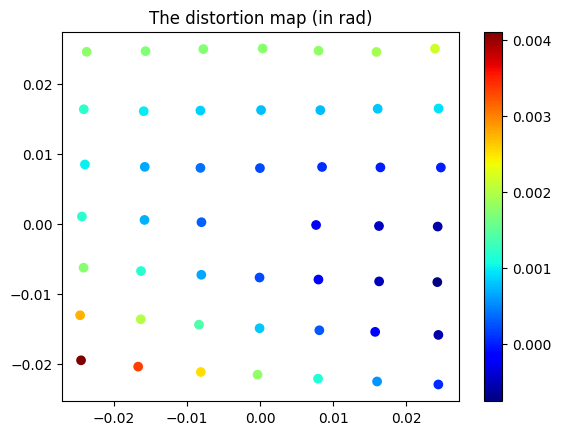

In [ ]:
plt.scatter(tiltx,np.matmul(Amatrix2,D_coef),c=Dtilty)
plt.colorbar()
plt.title("The distortion map (in rad)")

In [ ]:
Tilty_prime=np.insert(np.matmul(Amatrix2,D_coef),24,0)
Tilty_prime

array([-0.02289126, -0.02246416, -0.02206325, -0.02149122, -0.02111176,
       -0.02034674, -0.0194447 , -0.01582616, -0.01539145, -0.01516278,
       -0.01487169, -0.01436755, -0.01359471, -0.01302483, -0.00829492,
       -0.00819527, -0.00793196, -0.00764468, -0.00725369, -0.00672052,
       -0.00624054, -0.00037601, -0.0002999 , -0.00015222,  0.        ,
        0.00024227,  0.00056641,  0.00105568,  0.0080421 ,  0.00805817,
        0.00811972,  0.00795658,  0.0079867 ,  0.00813218,  0.008475  ,
        0.01645394,  0.01641644,  0.01622022,  0.01623187,  0.01615892,
        0.01607033,  0.01634791,  0.02499153,  0.02452055,  0.02469336,
        0.02501106,  0.02492564,  0.02463356,  0.02453952])

# See which terms are dominant

In [ ]:
Weights=np.zeros((num_terms,tiltx.shape[0]))

for tilts in range(Weights.shape[1]):
  terms=0
  for i in np.arange(Nmax+1):
      for j in np.arange(Nmax+1-i):
         if (i+j)!=0:
            Weights[terms,tilts]=abs(round(E_nm[terms]*tiltx[tilts]**i*tilty[tilts]**j/(-x_shift[tilts])*100,2))
            terms+=1
Weights=np.insert(Weights,24,0,axis=1)
Weights.shape

(14, 49)

0.0 1027.91


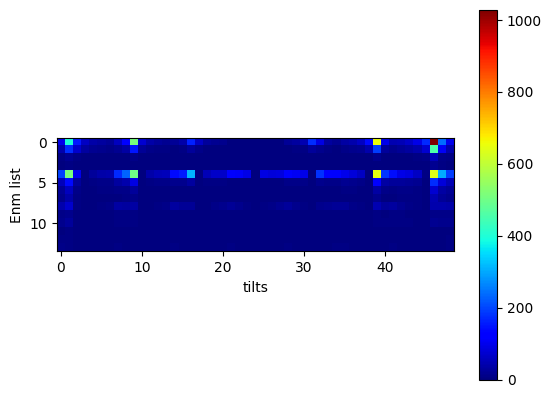

In [ ]:
plt.imshow(Weights)
plt.colorbar()
plt.xlabel('tilts')
plt.ylabel('Enm list')
print(Weights.min(),Weights.max())

The weight map for each aberration coefficient (%) (some coefficients make negative contribution to the X_shift, so it's not surprising that some weights are over 100%) The absolute values of the weights are taken.

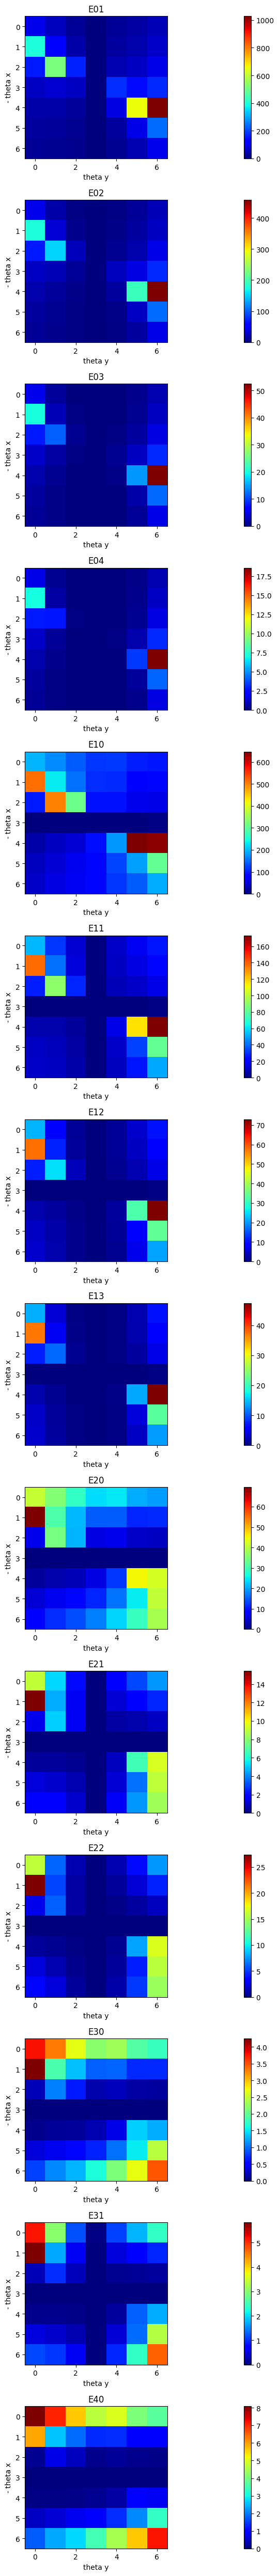

In [ ]:
fig, ax = plt.subplots(num_terms, figsize=(30, 50))
for i in range(num_terms):
  im=ax[i].imshow(np.transpose(Weights[i,:].reshape(7,7)))
  ax[i].set_title(list_of_Enm[i])
  ax[i].set_xlabel('theta y')
  ax[i].set_ylabel('- theta x')
  plt.colorbar(im, ax=ax[i])
plt.tight_layout()

# Evaluate the fitting visually by a colormap and surface plot of     X_shift( $\theta_{x},\theta_{x}$)

Calculate the X_shift as a function of tilts

In [ ]:
X_shift_cal=np.zeros((801,801))
for i,x in enumerate(range(-400,401)):
  for j,y in enumerate(range(-400,401)):
      tiltx=-calib_Ronchi_1*x
      tilty=calib_Ronchi_1*y
      terms=0
      for ii in np.arange(Nmax+1):
         for jj in np.arange(Nmax+1-ii):
             if (ii+jj)!=0: # exclude E00
                X_shift_cal[i,j]+=E_nm[terms]*tiltx**ii*tilty**jj
                terms+=1

Compare X_shift_cal (continuous colormap) with X_shift (colored dots) from the experiment

Text(0, 0.5, 'COM of EELS line profiles')

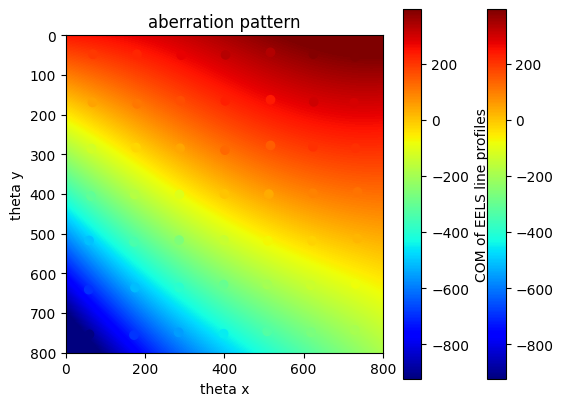

In [ ]:
plt.imshow(-X_shift_cal,vmax=(COM_EELS[:]*calib_EELS_1).max(),vmin=(COM_EELS[:]*calib_EELS_1).min())
plt.colorbar()
plt.scatter(COM_Ronchi[:,1]+400,COM_Ronchi[:,0]+400,c=COM_EELS[:]*calib_EELS_1)
plt.ylabel('theta y')
plt.xlabel('theta x')
plt.title('aberration pattern')
cbar=plt.colorbar()
cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)
# plt.colorbar()

In [ ]:
# plt.scatter(COM_Ronchi_low[:,1],COM_Ronchi_low[:,0],c=COM_EELS_low[:]*calib_EELS_1)
# plt.ylabel('tilt y')
# plt.xlabel('tilt x')
# plt.title('aberration pattern dominated by low order aberrations')
# cbar=plt.colorbar()
# cbar.ax.set_ylabel('COM of EELS line profiles', rotation=90)

In [ ]:
x = np.linspace(-400, 400, 801)
y = np.linspace(-400, 400, 801)

X, Y = np.meshgrid(x, y)

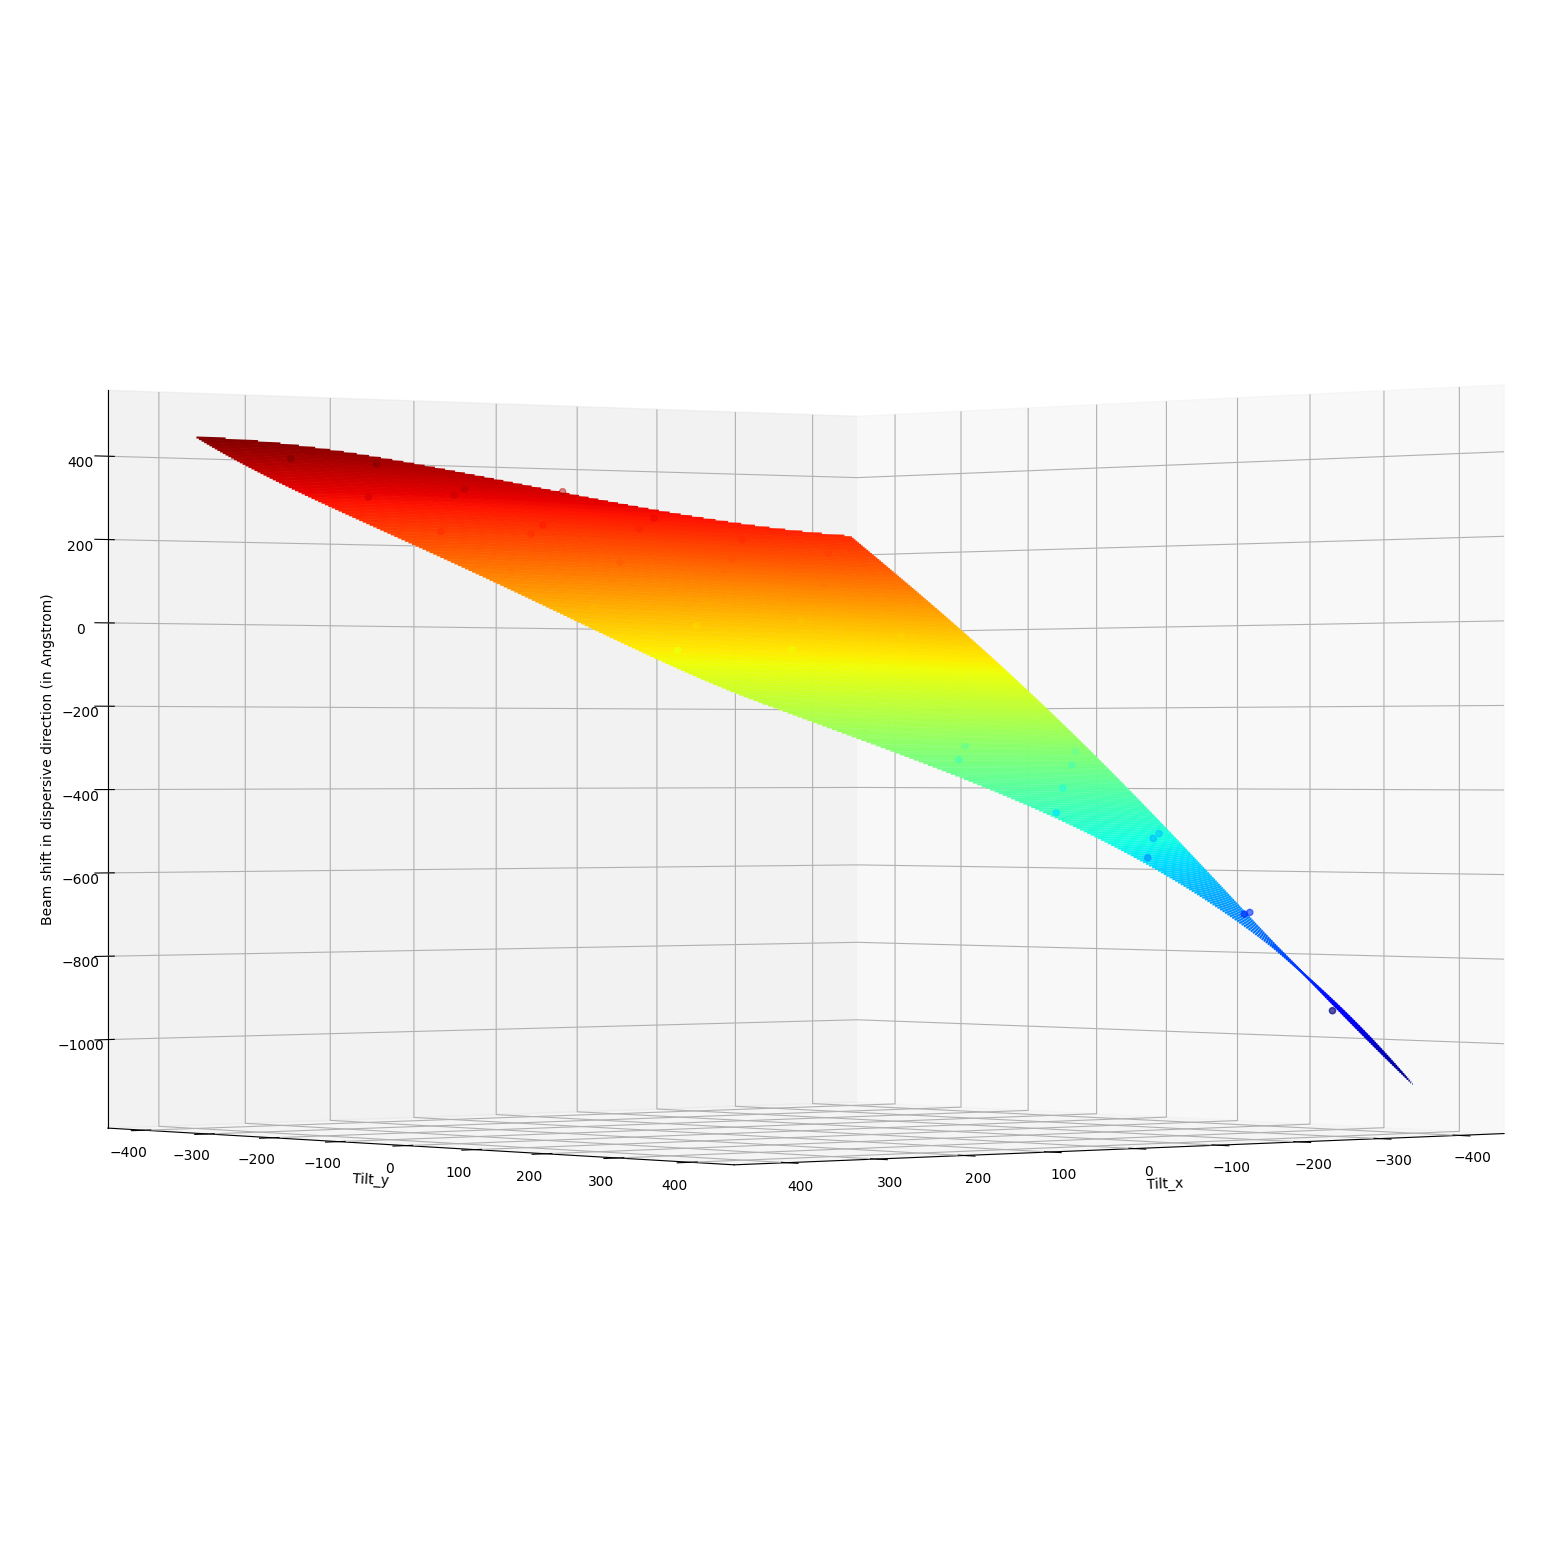

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, -X_shift_cal, 500, cmap='jet')
ax.scatter3D(COM_Ronchi[:,1],COM_Ronchi[:,0],COM_EELS[:]*calib_EELS_1,c=COM_EELS[:]*calib_EELS_1)
ax.set_xlabel('Tilt_x')
ax.set_ylabel('Tilt_y')
ax.set_zlabel('Beam shift in dispersive direction (in Angstrom)');
ax.view_init(0, 50) # change perspective by changing the angles in degrees

The fitting looks good for low and high but not for the best since the beam drift becomes dominant when E10 is very small.